In [2]:
from simulation.ComplexModeSimulation import ComplexModeSimulation
from model.MassExitTransaction import MassExitTransaction
import common
import matplotlib.pyplot as plt

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

mempool_data_during_congestion = common.doPreprocessing(common.get_mempool_dir_during_congestion())
mempool_data_no_congestion = common.doPreprocessing(common.get_mempool_dir_no_congestion())
blocks_data = common.get_blocks_data()
PROBLEMATIC_INTERVALS = common.get_problematic_intervals()

In [3]:
def buildTransactions(num_attacked_channels, fee_index_attacker, initial_tx_with_same_fee_attacker, isDynamic):
    transactions = []
    attackerTx = MassExitTransaction(isAttacker=True, num=num_attacked_channels, isDynamic=False)
    attackerTx.feeIndex = fee_index_attacker
    attackerTx.txWithSameFee = initial_tx_with_same_fee_attacker
    transactions.append(attackerTx)
    for _ in range(num_attacked_channels):
        tx = MassExitTransaction(isAttacker=False, num=1, isDynamic=isDynamic)
        transactions.append(tx)
    
    return transactions  

def runSimulation(sim, transactions, num_attacked_channels, to_self_delay):
    late_penalty_transactions = 0
    confirmedAllAttackerTxLogged = False
    honestIndex = 1
    sim.submitTransaction(transactions[0]) # we submit attacker txs
    last_num_attacker_txs = transactions[0].num
        
    print("[INFO] Starting simulation...")
    
    while sim.hasSnapshots():
        sim.run()
        remainingAttackerTxs = transactions[0].num
        
        if remainingAttackerTxs == 0 and not confirmedAllAttackerTxLogged:
            print(f"[INFO] All attacker transactions mined at block #{sim.blocksCounter}")
            confirmedAllAttackerTxLogged = True
        
        num_confirmed_attacker_txs = last_num_attacker_txs - remainingAttackerTxs
        newHonestIndex = honestIndex + num_confirmed_attacker_txs

        while honestIndex < newHonestIndex:
            honestTx = transactions[honestIndex]
            honestTx.submitted = True
            txsWithNumGreaterThanOne = [0] * len(fee_ranges)
            txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
            # with respect to the previous version of the simulation, the main thing that slightly changes results is the fee computation
            honest_fee_index, honest_fee = sim.getAverageFee(txsWithNumGreaterThanOne) # average or median ?
            honestTx.feeIndex = honest_fee_index
            honestTx.currentFee = honest_fee
            honestTx.txWithSameFee = sim.getTxWithSameFee(honest_fee_index)
            honestTx.attackerTxConfirmedBlockNumber = sim.blocksCounter
            honestIndex += 1
            sim.submitTransaction(honestTx)
        
            
        if sim.getConfirmedTxCount() == (2 * num_attacked_channels):
            print(f"[INFO] All transactions confirmed at block #{sim.blocksCounter}")
            
            for tx in transactions:
                if (not tx.isAttacker and tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber) > to_self_delay: 
                    late_penalty_transactions += 1
            print(f"[INFO] {late_penalty_transactions} late penalty transactions")        
            return late_penalty_transactions

        lastHonestTx = transactions[num_attacked_channels]
        if lastHonestTx.submitted and (sim.blocksCounter - lastHonestTx._attackerTxConfirmedBlockNumber) > to_self_delay:
            print(f"[INFO] {to_self_delay} blocks have passed since the last honest tx was submitted at block #{sim.blocksCounter}, ending simulation")
            
            for tx in transactions:
                n = tx.confirmedBlockNumber if tx.confirmed else sim.blocksCounter
                if not tx.isAttacker and n - tx.attackerTxConfirmedBlockNumber> to_self_delay: 
                    late_penalty_transactions += 1
            print(f"[INFO] {late_penalty_transactions} late penalty transactions")        
            return late_penalty_transactions

        last_num_attacker_txs = remainingAttackerTxs
        
    print(f"[WARN] Could not finish the simulation because all the time window has passed")
    return None


def runSimulationForAttackerProfit(sim, transactions, to_self_delay, attacker_fee_second_tx):
    confirmedAllAttackerTxLogged = False
    honestIndex = 1
    sim.submitTransaction(transactions[0]) # we submit attacker txs
    last_num_attacker_txs = transactions[0].num
    secondAttackerTransactions = []
    compromised_channels = 0    
    submittedHonestTxs = []
    attacker_fee_index_second_tx = common.find_index_of_fee_in_ranges(attacker_fee_second_tx)

    print("[INFO] Starting simulation...")
    
    while sim.hasSnapshots():
        sim.run()
        remainingAttackerTxs = transactions[0].num
        
        if remainingAttackerTxs == 0 and not confirmedAllAttackerTxLogged:
            print(f"[INFO] All fraudulent commitment transactions mined at block #{sim.blocksCounter}")
            confirmedAllAttackerTxLogged = True
        
        num_confirmed_attacker_txs = last_num_attacker_txs - remainingAttackerTxs
        newHonestIndex = honestIndex + num_confirmed_attacker_txs

        while honestIndex < newHonestIndex:
            submittedHonestTxs.append(honestIndex)
            honestTx = transactions[honestIndex]
            honestTx.submitted = True
            txsWithNumGreaterThanOne = [0] * len(fee_ranges)
            txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
            # with respect to the previous version of the simulation, the main thing that slightly changes results is the fee computation
            honest_fee_index, honest_fee = sim.getAverageFee(txsWithNumGreaterThanOne) # average or median ?
            honestTx.feeIndex = honest_fee_index
            honestTx.currentFee = honest_fee
            honestTx.txWithSameFee = sim.getTxWithSameFee(honest_fee_index)
            honestTx.attackerTxConfirmedBlockNumber = sim.blocksCounter
            honestIndex += 1
            sim.submitTransaction(honestTx)

        i = 0
        for index in submittedHonestTxs:
            tx = transactions[submittedHonestTxs[i]]
            b = sim.blocksCounter
            if not tx.confirmed and b - tx.attackerTxConfirmedBlockNumber >= to_self_delay: 
                secondAttackerTx = MassExitTransaction(True, 1, False)
                secondAttackerTx.submitted = True
                txsWithNumGreaterThanOne = [0] * len(fee_ranges)
                txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
                # with respect to the previous version of the simulation, the main thing that slightly changes results is the fee computation
                fee = attacker_fee_second_tx
                fee_index = attacker_fee_index_second_tx
                secondAttackerTx.feeIndex = fee_index
                secondAttackerTx.currentFee = fee
                secondAttackerTx.txWithSameFee = sim.getTxWithSameFee(fee_index)
                secondAttackerTx.penaltyTxIndex = index
                secondAttackerTransactions.append(secondAttackerTx)
                sim.submitTransaction(secondAttackerTx)
                submittedHonestTxs[i] = None
            i += 1
        
        submittedHonestTxs = list(filter(lambda i: i is not None, submittedHonestTxs))       
                
        if transactions[0].num == 0 and sim.allUserTxsConfirmed():
            for secondAttackerTx in secondAttackerTransactions:
                if (secondAttackerTx.confirmed and not transactions[secondAttackerTx.penaltyTxIndex].confirmed) or (secondAttackerTx.confirmed and transactions[secondAttackerTx.penaltyTxIndex].confirmed and secondAttackerTx.confirmedBlockNumber < transactions[secondAttackerTx.penaltyTxIndex].confirmedBlockNumber):
                    compromised_channels += 1
            print("Finished simulation")
            return compromised_channels
         

        last_num_attacker_txs = remainingAttackerTxs
        
    print(f"[WARN] Could not finish the simulation because all the time window has passed")
    return None    

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7530, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7367
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7468, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7130
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7231, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6959
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7060, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined a

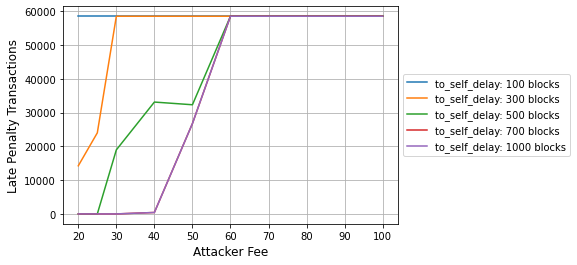

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7331
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7432, ending simulation
[INFO] 20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7165
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7266, ending simulation
[INFO] 20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6959
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7060, ending simulation
[INFO] 20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6858
[INFO] 100 blocks have passed since the last honest tx was submitted at block #6959, ending simulation
[INFO] 20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined a

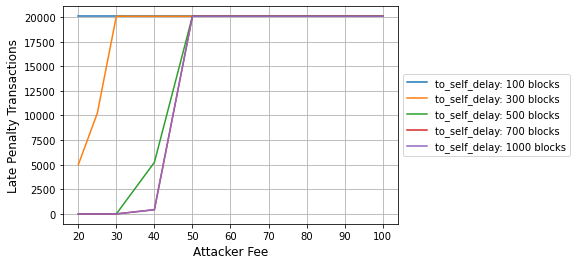

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #69
[INFO] 100 blocks have passed since the last honest tx was submitted at block #170, ending simulation
[INFO] 5774 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #68
[INFO] All transactions confirmed at block #158
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #67
[INFO] All transactions confirmed at block #156
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #67
[INFO] All transactions confirmed at block #129
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #67
[INFO] All transactions confirmed at block #124
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #67
[INFO] All

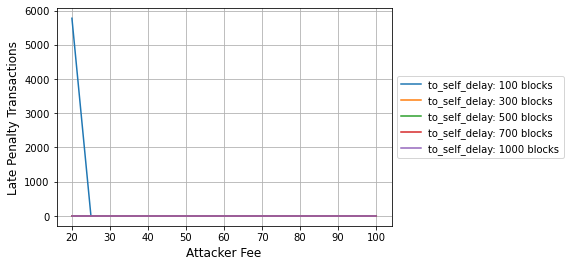

In [69]:
ln_delays = [100, 300, 500, 700, 1000]

# sim = ComplexModeSimulation(mempoolData=mempool_data_during_congestion, blocksData=blocks_data, isDynamic=False, firstBlockHeightOfSimulation=common.get_first_block_height_during_congestion(), problematicIntervals=PROBLEMATIC_INTERVALS, step=-1, beta=-1)
# transactions = buildTransactions(20084, 12, (sim.getFirstSnapshot())[1][12], False)
# n = runSimulation(sim, transactions, 20084, 300)

# print("-----------------------------------------")

# sim = ComplexModeSimulation(mempoolData=mempool_data_during_congestion, blocksData=blocks_data, isDynamic=False, firstBlockHeightOfSimulation=common.get_first_block_height_during_congestion(), problematicIntervals=PROBLEMATIC_INTERVALS, step=-1, beta=-1)
# transactions = buildTransactions(20084, 13, (sim.getFirstSnapshot())[1][13], False)
# n = runSimulation(sim, transactions, 20084, 300)


experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()

    for ln_delay in ln_delays:
        print(f"to_self_delay: {ln_delay} blocks")
        y = []
        x = []

        i = 13 # 12
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=False, firstBlockHeightOfSimulation=first_block_height, problematicIntervals=PROBLEMATIC_INTERVALS, step=-1, beta=-1)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], False)
            n = runSimulation(sim, transactions, n_attacked_channels, ln_delay)
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        
        plt.plot(x, y)   
        labels.append(f"to_self_delay: {ln_delay} blocks") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Late Penalty Transactions', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7456
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7441
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7189
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7120
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6838
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6779
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3765
Finished simu

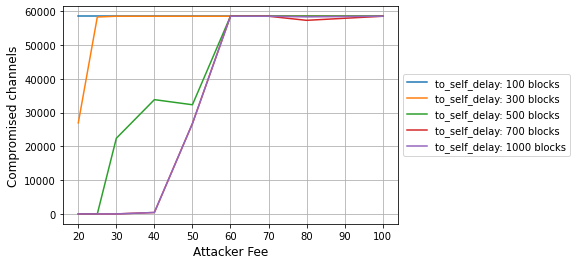

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7367
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7166
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6959
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6858
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3812
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3739
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #1623
Finished simu

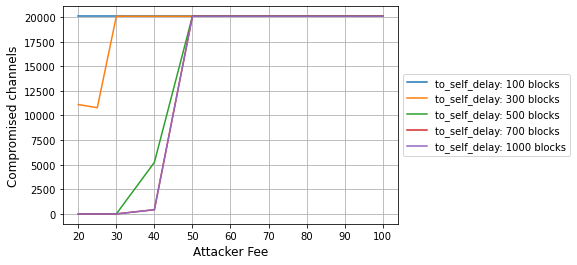

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #26
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
0 compromised channels
[INFO] S

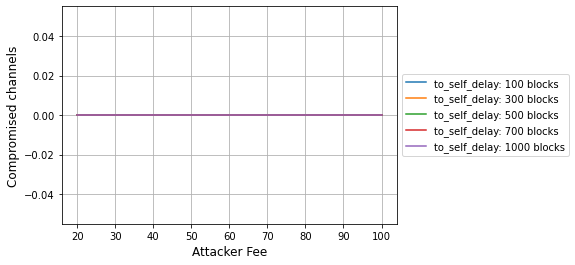

In [8]:
ln_delays = [100, 300, 500, 700, 1000]

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()

    for ln_delay in ln_delays:
        print(f"to_self_delay: {ln_delay} blocks")
        y = []
        x = []

        i = 13
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=False, firstBlockHeightOfSimulation=common.get_first_block_height_during_congestion(), problematicIntervals=PROBLEMATIC_INTERVALS, step=-1, beta=-1)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], False)
            n = runSimulationForAttackerProfit(sim, transactions, ln_delay, attacker_fee_second_tx=100)
            print(f"{n} compromised channels")
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        
        plt.plot(x, y)   
        labels.append(f"to_self_delay: {ln_delay} blocks") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Compromised channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7481
[INFO] All transactions confirmed at block #7549
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] All transactions confirmed at block #7581
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] All transactions confirmed at block #7639
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] All transactions confirmed at block #7671
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] All transactions confirmed at block #7659
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] All transactions confirmed at block #7661
[INFO] 0 late penalty trans

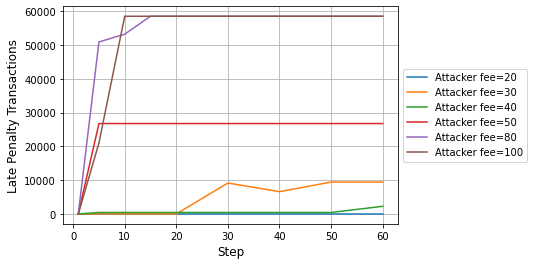

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7367
[INFO] All transactions confirmed at block #7436
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7331
[INFO] All transactions confirmed at block #7466
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7331
[INFO] All transactions confirmed at block #7496
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7331
[INFO] All transactions confirmed at block #7493
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7331
[INFO] All transactions confirmed at block #7511
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7331
[INFO] All transactions confirmed at block #7545
[INFO] 0 late penalty trans

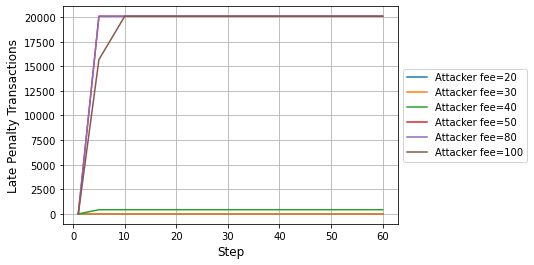

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #84
[INFO] All transactions confirmed at block #150
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #69
[INFO] All transactions confirmed at block #167
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #69
[INFO] All transactions confirmed at block #172
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #69
[INFO] All transactions confirmed at block #171
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #69
[INFO] All transactions confirmed at block #172
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #69
[INFO] All transactions confirmed at block #172
[INFO] 0 late penalty transactions
[INFO] Sta

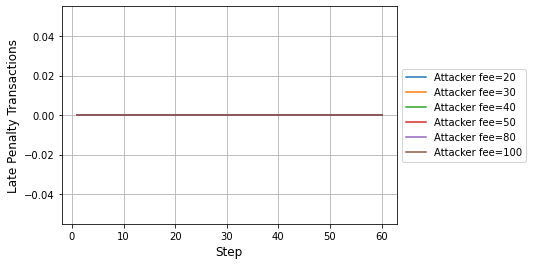

In [9]:
ln_delay = 539
attacker_fees = [20, 30, 40, 50, 80, 100]

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

beta = 1.01
#steps = [1, 3, 5, 10, 30]
#steps = [1, 5, 10, 15, 20, 25, 30] 
steps = [1, 5, 10, 15, 20, 30, 40, 50, 60] 

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()

    for attacker_fee in attacker_fees:
        fee_index = common.find_index_of_fee_in_ranges(attacker_fee)
        y = []
        x = []
        for step in steps:
            sim = ComplexModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=True, firstBlockHeightOfSimulation=first_block_height, problematicIntervals=PROBLEMATIC_INTERVALS, step=step, beta=beta)
            transactions = buildTransactions(n_attacked_channels, fee_index, (sim.getFirstSnapshot())[1][fee_index], True)
            n = runSimulation(sim, transactions, n_attacked_channels, ln_delay)
            y.append(n)
            x.append(step)
        plt.plot(x, y)   
        labels.append(f"Attacker fee={attacker_fee}") 
        i += 1

    plt.xlabel('Step', fontsize=12) 
    plt.ylabel(f'Late Penalty Transactions', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7487
[INFO] All transactions confirmed at block #7576
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7481
[INFO] All transactions confirmed at block #7549
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7465
[INFO] All transactions confirmed at block #7542
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7350
[INFO] All transactions confirmed at block #7427
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7104
[INFO] All transactions confirmed at block #7192
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6843
[INFO] All transactions confirmed at block #6932
[INFO] 0 late penalty trans

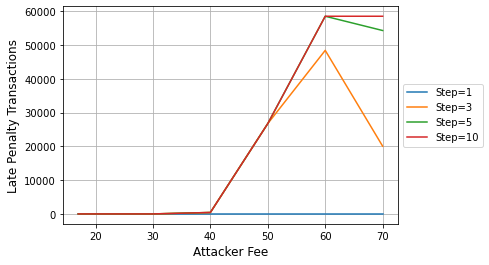

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7379
[INFO] All transactions confirmed at block #7455
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7367
[INFO] All transactions confirmed at block #7436
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7165
[INFO] All transactions confirmed at block #7325
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6959
[INFO] All transactions confirmed at block #7044
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6858
[INFO] All transactions confirmed at block #6983
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #3812
[INFO] All transactions confirmed at block #4099
[INFO] 0 late penalty trans

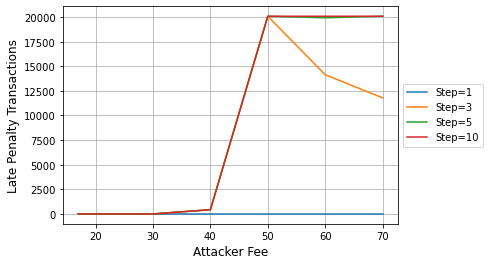

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #84
[INFO] All transactions confirmed at block #150
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #84
[INFO] All transactions confirmed at block #150
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #83
[INFO] All transactions confirmed at block #134
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #82
[INFO] All transactions confirmed at block #125
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #82
[INFO] All transactions confirmed at block #122
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #82
[INFO] All transactions confirmed at block #121
[INFO] 0 late penalty transactions
[INFO] Sta

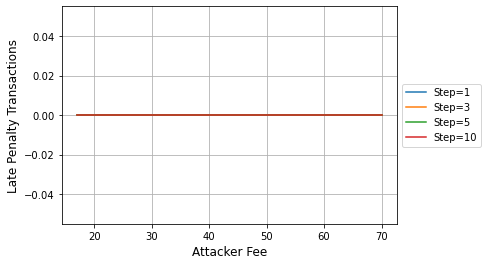

In [16]:
ln_delay = 539

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

beta = 1.01
steps = [1, 3, 5, 10]#[1, 10, 20, 40, 50] 

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()

    for step in steps: # inverti steps and fee
        y = []
        x = []
        i = 12 # 12
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70]#, 80, 100 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=True, firstBlockHeightOfSimulation=first_block_height, problematicIntervals=PROBLEMATIC_INTERVALS, step=step, beta=beta)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], True)
            n = runSimulation(sim, transactions, n_attacked_channels, ln_delay)
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        plt.plot(x, y)   
        labels.append(f"Step={step}") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Late Penalty Transactions', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7487
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7481
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7465
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7350
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7104
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6843
Finished simulation
step=1, attacker fee index=1

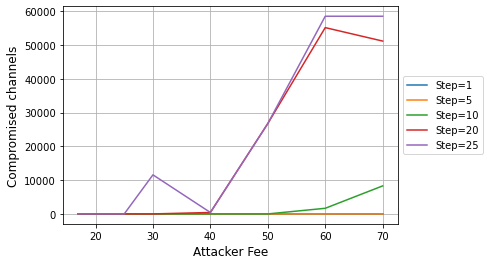

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7379
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7367
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7165
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6959
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6858
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3812
Finished simulation
step=1, attacker fee index=1

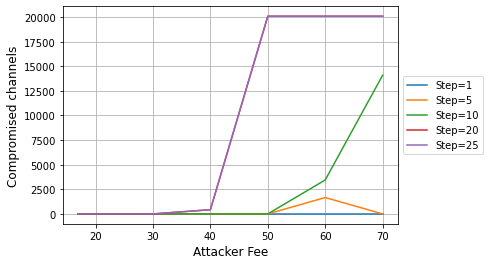

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #27
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #26
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #25
Finished simulation
step=1, attacker fee index=17, 0 comprom

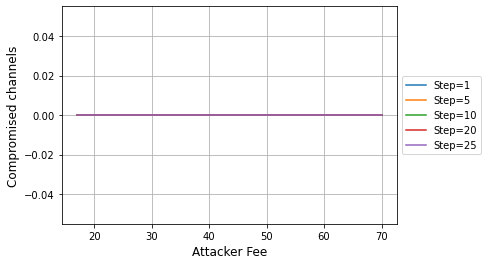

In [17]:
ln_delay = 539

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

beta = 1.01
steps = [1, 5, 10, 20, 25]#[1, 5, 10, 15, 20, 25, 30] 

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    mempool_data = mempool_data_during_congestion if experiment["scenario"] == 1 else mempool_data_no_congestion
    first_block_height = common.get_first_block_height_during_congestion() if experiment["scenario"] == 1 else common.get_first_block_height_no_congestion()

    for step in steps: # inverti steps and fee
        y = []
        x = []
        i = 12 # 12
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70]#, 80, 100 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=True, firstBlockHeightOfSimulation=common.get_first_block_height_during_congestion(), problematicIntervals=PROBLEMATIC_INTERVALS, step=step, beta=beta)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], True)
            n = runSimulationForAttackerProfit(sim, transactions, ln_delay, attacker_fee_second_tx=100)
            print(f"step={step}, attacker fee index={i}, {n} compromised channels")
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        plt.plot(x, y)   
        labels.append(f"Step={step}") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Compromised channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()